

















<font size="3">**Tarea 1 2025**</font>

Juan Acevedo Fuentes

2020770859

Jacevedo2020@udec.cl

<u> *Instrucciones* </u>

Su notebook con las respuestas a la tarea se deben entregar a mas tardar el dia 21/04/25 hasta las 21:00, subiendolo al repositorio en la carpeta tareas/2025. 

Es importante considerar que el código debe poder ejecutarse en cualquier computadora con la data original del repositorio. Recordar la convencion para el nombre de archivo ademas de incluir en su documento titulos y encabezados por seccion. La data a utilizar es **machine_failure_data.csv**.

Las variables tienen la siguiente descripcion:

- Date: data medida en frecuencia diaria
- Location: ubicacion del medidor
- Min_Temp: temperatura minima observada
- Max_Temp: temperatura maxima observada
- Leakage: Filtracion medida en el area
- Evaporation: Tasa de evaporacion
- Electricity: Consumo electrico KW
- Parameter#: Diferentes sensores de reportando direccion y velocidad de viento en distintos momentos del dia, asi como otras metricas relevantes.
- Failure today: El sensor reporta fallo (o no)

1. Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario. 

**R**: Al momento de cargar los datos se estudiaron cada variable para entender su funcionamiento y su signifcado en las mediciones. Los puntos a resaltar y que son utiles para continuar con la tarea son los siguientes:

- Los datos fueron registrados desde 2007 a 2017 donde en los primeros 2 años (2007 y 2008) Solo habian un par de localizaciones las cuales registrar. por ello para realizar el modelo se decidio ignorar esos primeros años. El  año 2017 posee pocos datos porque la recoleccion de datos termino en junio, aun asi se consierará.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [ ]:
df = pd.read_csv('../../data/machine_failure_data.csv')
df.reset_index(drop=True, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year

sns.countplot(data=df, x='Year', hue='Failure_today')

#Hasta 2009 solo se usaca la localizacion 3 luego se emepzo a medir en las otras localizaciones lo cual suma bastante al conteo
#Parece que los datos se mantienen estables en el tiempo pero.... que paso en 2017?? Segun vi en la data puede que 2017 llega hasta solo agosto mes 6
df = df[(df['Year'] >= 2009) & (df['Year'] <= 2017)]
df['Month'] = df['Date'].dt.month
#sns.countplot(data=df, x='Year', hue='Failure_today')


- Se Estudiaron las distribuciones de los demas parametros y podemos resaltar como en las filtraciones ("Leakage") tiene un comportamiento casi binaria donde casi el 99% de los registros donde las maquinas no fallan da 0 filtraciones y cuando falla es donde las filtraciones toman valores distintos de 0. Esto nos presenta una distribucion logaritmica debido a que cuando se generan filtraciones algunas veces toma valores bastante grandes. Paraestandarizar los parametros se utilizó la siguiente funcion:   Log(Filtraciones + 1), la constante se sumo para evitar el problema de aplicar logaritmo a un 0 que da como resultado menos infinito

In [ ]:
 #Estandarizado por log de leakage
filtro_failure = df['Failure_today'] == 'Yes'
epsilon = 1
df['Log_Leakage'] = np.log(df['Leakage'] + epsilon)
leak_failure = pd.DataFrame(df['Log_Leakage'][filtro_failure])


sns.kdeplot(data=df, x='Log_Leakage', color='orange')

<Axes: xlabel='Normal_Leakage', ylabel='Density'>

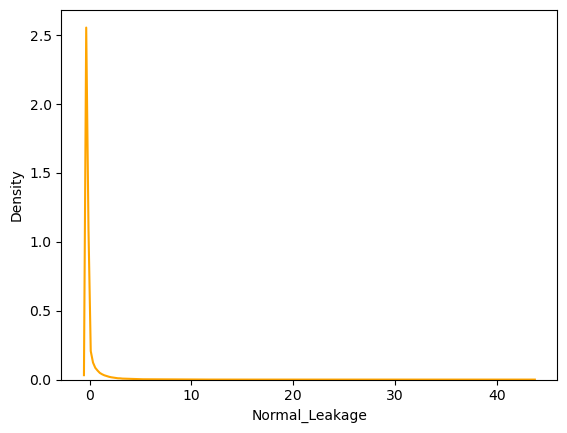

In [200]:
#Estandarizado comun de leakage
media = (df['Leakage']+epsilon).mean()
varianza = (df['Leakage']+epsilon).var() #En varianza no deberia afectar en nada pero por si acaso

df['Normal_Leakage'] = (df['Leakage']+epsilon - media)/np.sqrt(varianza)

#print('Sinceramente comparando ambos metodos de estandarizacion, me parece una mejor opcion la logaritima con un epsilon bajo')
sns.kdeplot(data=df, x='Normal_Leakage', color='orange')

Debido a su alta relación con la variable dependiente se decidio omitir las filtraciones a los modelos. 

- Se analizó la proporcion de los registros faltantes por cada variable para así escoger los parametros mas completos que correalaciones lo suficiente para reemplazar estas variables.

    - Electricidad: 47%
    - Evaporacion: 42%
    - Parametro 6: 37%

- Se crearon variables categoricas para las variables de direccion (Parameter1_Dir, Parameter2_9am y 3pm) separandolas por direccion del viento (norte, sur, este oeste). ademas de categorizar los meses en estaciones del año. Como resultado se obtuvo que la direccion del viento no fue significativa para nuestro modelo (Ver anexo)

In [201]:
#categorizar direcciones del viento
df['Is_P1Dir_North'] = df['Parameter1_Dir'].map({'NNW':1, 'N':1,'NNE':1,'NE':1,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

#categorizar direcciones del viento
df['Is_P1Dir_West'] = df['Parameter1_Dir'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':1,'W':1, 'WNW':1,'NW':1})

#categorizar direcciones del viento
df['Is_P1Dir_South'] = df['Parameter1_Dir'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':1,'S':1,'SSW':1,'SW':1,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

df['Is_P1Dir_East'] = df['Parameter1_Dir'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':1,'E':1,'ESE':1,'SE':1,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

#Cargorizar direcciones del parametro 2 de 9am
df['Is_P29am_North'] = df['Parameter2_9am'].map({'NNW':1, 'N':1,'NNE':1,'NE':1,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

df['Is_P29am_West'] = df['Parameter2_9am'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':1,'W':1, 'WNW':1,'NW':1})

df['Is_P29am_South'] = df['Parameter2_9am'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':1,'S':1,'SSW':1,'SW':1,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

df['Is_P29am_East'] = df['Parameter2_9am'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':1,'E':1,'ESE':1,'SE':1,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

#Cargorizar direcciones del parametro 2 de 3pm
df['Is_P23pm_North'] = df['Parameter2_3pm'].map({'NNW':1, 'N':1,'NNE':1,'NE':1,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

df['Is_P23pm_West'] = df['Parameter2_3pm'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':1,'W':1, 'WNW':1,'NW':1})

df['Is_P23pm_South'] = df['Parameter2_3pm'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':1,'S':1,'SSW':1,'SW':1,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

df['Is_P23pm_East'] = df['Parameter2_3pm'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':1,'E':1,'ESE':1,'SE':1,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

In [202]:
#Categorizar meses en estaciones
# inv: diciembre-marzo, primavera: marzo-junio, verano: junio-septiembre, otoño: septiembre-diciembre
df['Is_Summer'] = df['Month'].map({ 12:0, 1:0, 2:0,
                                   3:0, 4:0, 5:0,
                                   6:1, 7:1, 8:1,
                                   9:0, 10:0, 11:0})

df['Is_Winter'] = df['Month'].map({12:1, 1:1, 2:1,
                                   3:0, 4:0, 5:0,
                                   6:0, 7:0, 8:0,
                                   9:0, 10:0, 11:0})

df['Is_Fall'] = df['Month'].map({12:0, 1:0, 2:0,
                                   3:0, 4:0, 5:0,
                                   6:0, 7:0, 8:0,
                                   9:1, 10:1, 11:1})

df['Is_Spring'] = df['Month'].map({12:0, 1:0, 2:0,
                                   3:1, 4:1, 5:1,
                                   6:0, 7:0, 8:0,
                                   9:0, 10:0, 11:0})


- Se realizó una martiz de calor presentando la correlacion entre las variables para eliminar las que posean alta correlación entre si. además de buscar reemplazos para las que posean data faltante

<Axes: >

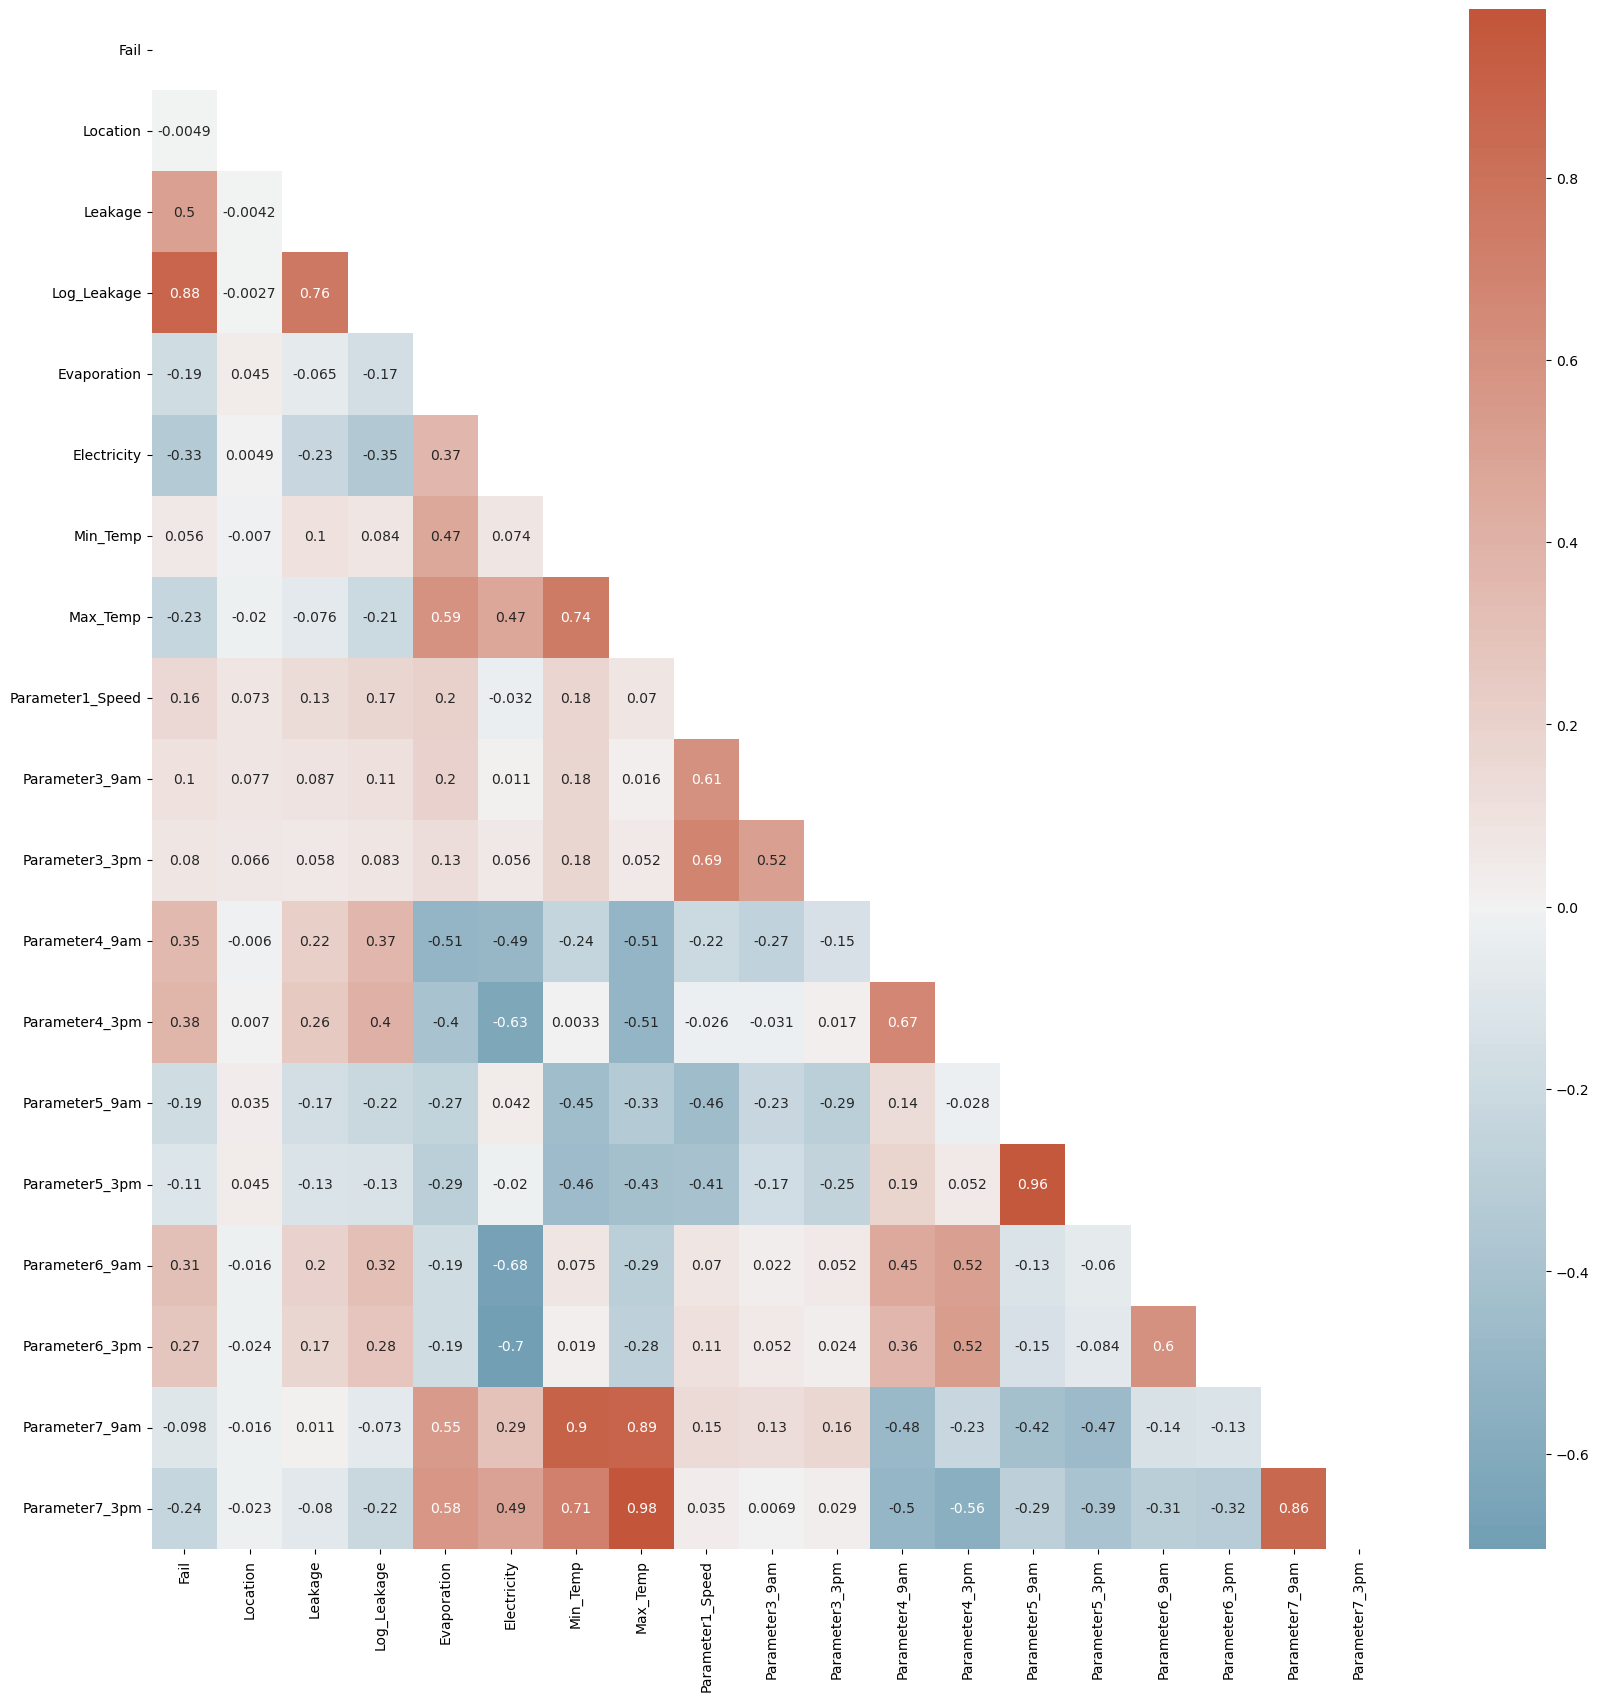

In [203]:
#Hay que convertir en binaria las variable de Failure, Yes = 1 No = 0 y eliminar las NaN
#Hacer matriz de covarianza para descartar algunas que se describen con otras

df = df[df['Failure_today'].notna()]
df['Fail'] = df['Failure_today'].apply(lambda x: 1 if x == 'Yes' else 0)


DF = df[['Fail','Location','Leakage','Log_Leakage', 'Evaporation', 'Electricity','Min_Temp', 'Max_Temp','Parameter1_Speed',
         'Parameter3_9am','Parameter3_3pm','Parameter4_9am','Parameter4_3pm','Parameter5_9am','Parameter5_3pm',
         'Parameter6_9am','Parameter6_3pm','Parameter7_9am','Parameter7_3pm']]
corr = DF.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, annot=True, cmap=cmap, center=0,mask=mask, )

2. Ejecute un modelo de probabilidad lineal (*MCO*) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 


Variable dependiente: Fail (Sí falla la maquina)

se seleccionaron las siguientes variables para los modelos:


- Location           
- Min_Temp            
- Max_Temp           
- Parameter1_Speed     
- Parameter3_9am     
- Parameter3_3pm     
- Parameter4_9am     
- Parameter4_3pm    
- Parameter5_9am      
- Is_Summer           
- Is_Fall              
- Is_Spring 

Para las estaciones se escogió la estacion de invierno como la variable categorica base para evaluar como varia el estar en otra estacion en comparacion a estar en invierno.

In [204]:
#Regresion excluyendo variables de alta correlacion





funcion = df.drop(['Date','Evaporation','Electricity', 
                   'Parameter1_Dir','Parameter2_9am','Parameter2_3pm', 'Is_P1Dir_West', 'Is_P1Dir_South', 'Is_P1Dir_East', 'Is_P1Dir_North',
                   'Is_P29am_North', 'Is_P29am_West', 'Is_P29am_South', 'Is_P29am_East',
                   'Is_P23pm_North', 'Is_P23pm_West', 'Is_P23pm_South', 'Is_P23pm_East',
                   'Failure_today', 'Year', 'Month', 'Is_Winter',
                    'Parameter5_3pm', 'Parameter6_9am','Parameter6_3pm','Parameter7_9am','Parameter7_3pm', 'Normal_Leakage','Leakage','Log_Leakage'], axis=1)
#funcion = funcion[~funcion.isna().any(axis=1)] 
funcion.dropna(inplace=True)



y=funcion['Fail']
X=funcion.drop(['Fail'], axis=1)

X=sm.add_constant(X)

In [205]:
model = sm.OLS(y, X)
results = model.fit(cov_type='HC0')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Fail   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     3561.
Date:              jue., 24 abr. 2025   Prob (F-statistic):               0.00
Time:                        21:46:30   Log-Likelihood:                -45616.
No. Observations:              117829   AIC:                         9.126e+04
Df Residuals:                  117816   BIC:                         9.138e+04
Df Model:                          12                                         
Covariance Type:                  HC0                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.6130      0.209  


3. Ejecute un modelo *probit* para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

Para el modelo de Probit y Logit se mantuvieron las mismas variables

In [206]:
model = sm.Probit(y, X)
probit_model = model.fit()
print(probit_model.summary())

mfx = probit_model.get_margeff()
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.368592
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                   Fail   No. Observations:               117829
Model:                         Probit   Df Residuals:                   117816
Method:                           MLE   Df Model:                           12
Date:              jue., 24 abr. 2025   Pseudo R-squ.:                  0.3023
Time:                        21:46:31   Log-Likelihood:                -43431.
converged:                       True   LL-Null:                       -62246.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               29.9610      0.851     35.200      0.000      28.293      31.629
Location   

4. Ejecute un modelo *logit*  para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

In [207]:
#Los modelos logit y probit tienen cte muuy grandes porque a mas grande la ecuacion del logit// dara 0
#Osea esta forzando que de 0 

model = sm.Logit(y, X)
logit_model = model.fit()
print(logit_model.summary())

mfx = logit_model.get_margeff()
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.368095
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   Fail   No. Observations:               117829
Model:                          Logit   Df Residuals:                   117816
Method:                           MLE   Df Model:                           12
Date:              jue., 24 abr. 2025   Pseudo R-squ.:                  0.3032
Time:                        21:46:32   Log-Likelihood:                -43372.
converged:                       True   LL-Null:                       -62246.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               50.6764      1.494     33.923      0.000      47.748      53.604
Location   

5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R**: Segun los resultados obtenidos en los modelos de minimos cuadrados, probit y logit podemos concluir a travez de el valor de R cuadrado los modelos probit y logit explican mas la variable dependiente que minimos cuadrados (aun asi es un valor bastante bajo), eso significa que es mejor usar los ultimos dos modelos para explicar las variables no lineales. Aun asi presentamos dificultades en la estimacion debido a falta de variables mas representativas (se explico previamente porqué no se uso "Leakage").

Para los resultados obtenidos entre probit y logit comparamos los coeficientes marginales y no descubrimos diferencia significativa entre las variables para encontrar un modelo mejor que el otro, podriamos decir que para las variables escogidas es irrelevante cual modelo se usa. 

Variables robustas a la especificacion: 


6. Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

Estudiando la data en excel, a travez de tablas dinamicas se pudo ver facilmmente como hay localizaciones los cuales jamas en los 10 años de estudio se midieron el consumo electrico o la evaporacion, eso explica los datos faltantes en esas columnas (al igual que en el parammetro 6). Por lo que se presentan casi la mitad de la data faltante en estas variables por lo que otra vez no se considerarán para los estudios siguientes.

Para correr el codigo se agruparon las localizaciones en 15 variables dummies.

In [208]:
df_mensual = df.drop(['Date','Failure_today',
                   'Parameter1_Dir','Parameter2_9am','Parameter2_3pm', 'Is_P1Dir_West', 'Is_P1Dir_South', 'Is_P1Dir_East', 'Is_P1Dir_North',
                   'Is_P29am_North', 'Is_P29am_West', 'Is_P29am_South', 'Is_P29am_East',
                   'Is_P23pm_North', 'Is_P23pm_West', 'Is_P23pm_South', 'Is_P23pm_East',

                    ], axis=1)



# Creamos un diccionario con funciones agregadas
agg_dict = {col: 'mean' for col in df_mensual.columns if col not in ['Year', 'Month', 'Location', 'Fail']}
agg_dict['Fail'] = 'sum'

# Aplicamos el groupby con agregación personalizada
df_mensual = df_mensual.groupby(['Year', 'Month', 'Location']).agg(agg_dict).reset_index()

#df_mensual['Has_Failed'] = df_mensual['Fail'].apply(lambda x: 1 if x != 0.0 else 0)
#df_mensual

### Poisson

In [209]:
df_mensual['Location_group'] = pd.cut(df_mensual['Location'], bins=15, labels=False)

In [210]:
poisson = smf.poisson("Fail ~ C(Location_group) + Min_Temp + Max_Temp + Parameter1_Speed + Parameter3_9am + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am + Is_Summer + Is_Fall + Is_Spring + C(Year)", data=df_mensual).fit()
print(poisson.summary())

Optimization terminated successfully.
         Current function value: 2.280935
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                   Fail   No. Observations:                 4076
Model:                        Poisson   Df Residuals:                     4042
Method:                           MLE   Df Model:                           33
Date:              jue., 24 abr. 2025   Pseudo R-squ.:                  0.3101
Time:                        21:46:33   Log-Likelihood:                -9297.1
converged:                       True   LL-Null:                       -13476.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  29.3098      2.828     10.363      0.000      23.766   

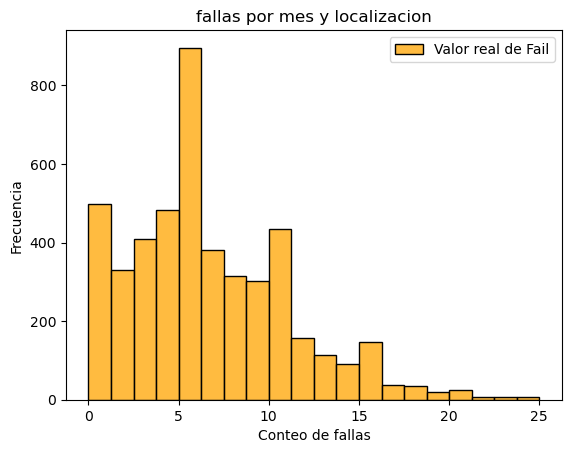

In [211]:

sns.histplot(df_mensual['Fail'], bins=20, kde=False, color='Orange', label='Valor real de Fail')
plt.xlabel('Conteo de fallas')
plt.ylabel('Frecuencia')
plt.title('fallas por mes y localizacion')
plt.legend()
plt.show()

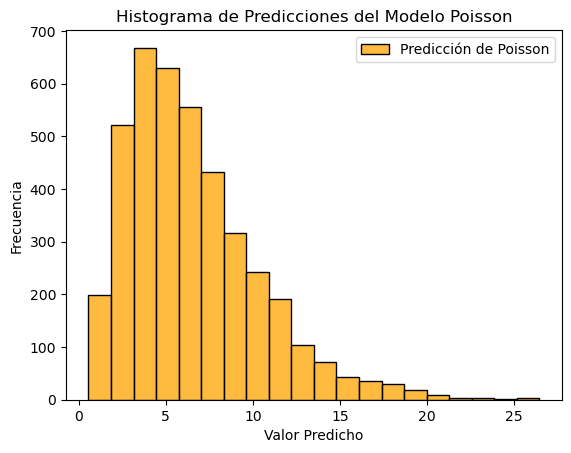

In [212]:
predictions = poisson.predict(df_mensual)
#print(predictions)
sns.histplot(predictions, bins=20, kde=False, color='Orange', label='Predicción de Poisson')
plt.xlabel('Valor Predicho')
plt.ylabel('Frecuencia')
plt.title('Histograma de Predicciones del Modelo Poisson')
plt.legend()
plt.show()

Segun el entrenamiento, usando poisson.predict nos presenta que su estimacion se acerca bastante poco al caso real aunque nunca presenta un valor estrictamente 0, debe ser por su caracteristica de ser un estimador. Ademas de acuerdo a los resultados del modelo se concluye lo siguiente:
- Con el R cuadrado vemos que el modelo explica alrededor de un 20% de la data real
- Si la maquina trabaja en las estaciones de otoño y primavera aumenta la cantidad de fallas en 0.21 y 0.11 respectivamente 
- En general como en Poisson las variables de los años no son significativos para el modelo
- las variables que favorecerian a reducir la cantidad de fallas en un mes son: los parametros 5, 3, temperatura maxima
- Muchos de los grupos de localizaciones son significativas para el modelo y con un coeficiente negativo donde indica en su mayoria los grupos de localizaciones suelen tener menos de 29 fallas.

7. Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.



**R**: Para estudiar la sobredispersion de la data debemos comparar la media y la varianza de cuantas fallas hay. 
- Media < Varianza: Sobredispersion
- Media > Varianza: Subdispersion

In [213]:
#Alpha es la estimacion de de la dispersion de la data
var = df_mensual['Fail'].var()
media = df_mensual['Fail'].mean()

print("Media:", media)
print("Varianza:", var)

Media: 6.592410999786826
Varianza: 19.665818727417918


Al parecer se nos presenta el caso de sobredispercion por lo que es mejor utilizar el modelo de Binomial negativa ya que esta es util cuando se presenta sobredispersion.

Para calcular alpha debe resolver lo siguiente:
$\alpha = \frac{\text{Varianza} - \mu}{\mu^2}$

In [214]:
print("Alpha:", (var-media)/media**2)

Alpha: 0.3008155312053915


8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 



In [215]:
nbin = smf.negativebinomial("Fail ~  Min_Temp + Max_Temp + Parameter1_Speed + Parameter3_9am + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am + Is_Summer + Is_Fall + Is_Spring + C(Year)+C(Location_group)", data=df_mensual).fit()
print(nbin.summary())

         Current function value: 2.280852
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48
                     NegativeBinomial Regression Results                      
Dep. Variable:                   Fail   No. Observations:                 4076
Model:               NegativeBinomial   Df Residuals:                     4042
Method:                           MLE   Df Model:                           33
Date:              jue., 24 abr. 2025   Pseudo R-squ.:                  0.1935
Time:                        21:46:34   Log-Likelihood:                -9296.8
converged:                      False   LL-Null:                       -11528.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  29.3098      2.861     

De acuerdo a los resultados entregados podemos destacar lo siguiente.
- Segun el R cuadrado el modelo explica un 17% de la variable dependiente es un resultado bastante bajo y debe ser porque faltan variables relevantes que no se midieron

los coeficientes se mentienen similares a los del modelo de poisson y el histograma se mantiene similar al poisson

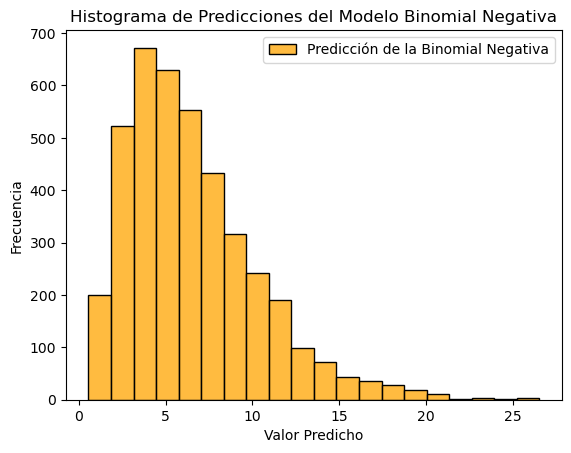

In [216]:
predictions=nbin.predict(df_mensual)

sns.histplot(predictions, bins=20, kde=False, color='Orange', label='Predicción de la Binomial Negativa')
plt.xlabel('Valor Predicho')
plt.ylabel('Frecuencia')
plt.title('Histograma de Predicciones del Modelo Binomial Negativa')
plt.legend()
plt.show()

9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R**: Segun lo analizado no se encuentra mucha diferencia entre los modelos poisson y binomial, aunque el primero al parecer explica mejor la data, aunque haya sobredispersion no parece ser demasiada como para ser extrictamente necesario usar el modelo de la Binomial negativa ya que su alpha es cercano a 0 (aunque la varianza es muy grande). Se deberan analizar mas parametros no estudiados para estimar mejor la data ya que como se vio previamente en el mapa de calor muchos de las variables independientes no poseen una alta correlacion con la dependiente (excepto las filtraciones).